## Autor: Leonardo França Bessa

### Objetivo do notebook: Capturar palavras chaves de reviews do produto Alexa da Amazon

### Importância da extração de palavras chaves:

A extração de palavras-chave (também conhecida como detecção de palavras-chave ou análise de palavras-chave) é uma técnica de análise de texto que extrai automaticamente as palavras e expressões mais usadas e importantes de um texto. Ajuda a resumir o conteúdo dos textos e reconhecer os principais tópicos discutidos.

Com a extração de palavras-chave, você pode encontrar as palavras e frases mais importantes em grandes conjuntos de dados em apenas alguns segundos para obter insights valiosos sobre os tópicos de que seus clientes estão falando.

- Escalabilidade:
 A extração automatizada de palavras-chave permite que você analise quantos dados desejar. Sim, você poderia ler textos e identificar os termos-chave manualmente, mas seria extremamente demorado. Automatizar essa tarefa dá a você a liberdade de se concentrar em outras partes do seu trabalho.

- Critérios consistentes:
 A extração de palavras-chave atua com base em regras e parâmetros predefinidos. Você não precisa lidar com inconsistências, que são comuns na análise de texto manual.

- Análise em tempo real:
 Você pode realizar a extração de palavras-chave em postagens de mídia social, avaliações de clientes, pesquisas ou tíquetes de suporte ao cliente em tempo real e obter insights sobre o que está sendo dito sobre seu produto conforme eles acontecem e acompanhá-los ao longo do tempo.

### Dataset
- Este conjunto de dados consiste em cerca de 3.000 avaliações de clientes da Amazon, sobre o produto Alex/Echo.
- Disponível em: https://www.kaggle.com/sid321axn/amazon-alexa-reviews

### Organização do notebook:
- O nome das sessões esta em inglês.
- Comentários e observações/insights estão em português.

# Import's

In [3]:
#Utilitarios
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
from sklearn.preprocessing import StandardScaler

#ferramentas de NLP
import nltk 
from nltk.stem import WordNetLemmatizer 
from pattern.en import suggest 
import spacy
import en_core_web_sm

#Visualização
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
import scattertext as st
from scattertext import CorpusFromPandas, produce_scattertext_explorer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from gensim.models import word2vec

#Palavras Chave
from mrakun import RakunDetector
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.summarization import keywords
import RAKE
import yake
import pke
from pke import compute_document_frequency

#Metricas


import warnings
warnings.filterwarnings("ignore")
from IPython.display import IFrame

In [3]:
data = pd.read_csv('amazon_alexa.tsv', sep='\t')

# Data Info

In [6]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


#### Rating: nota que o usuário deu ao produto
#### Date: data da publicação da crítica
#### Variation: variação da Alexa
#### Verified_reviews: texto da crítica
#### Feedback: 1 = positivo; 0 = negativo

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


##### Sem valores faltantes

In [8]:
#trocar nome das colunas
data.columns = ['rating', 'date', 'variation', 'review', 'feedback']
#feedback de int para string, para processamentos futuros
data['feedback'] = data['feedback'].apply(str)

### Criar cópia para o preprocessamento

In [9]:
df = data.copy()

# Data Preprocessing

###### Limpando o texto

Remover pontuações, números, caracteres especiais e deixar o texto em minúsculo.

In [76]:
def clean_text(x):
    text = x
    text = text.lower() #minúsculo
    text = re.sub(r'[^\w\s]','',text) # remover pontuação
    text = re.sub('\w*\d\w*', '', text) # remover numeros
    text = re.sub('\n', '', text) #remove enters
    return text

In [11]:
df['review'] = df['review'].apply(lambda x: clean_text(x))

##### Correção de palavras escritas errado (execução lenta)

Como estamos lidando com comentarios de usuários, é bem possível que algumas palavras sejam escritas de forma errada ou estejam abreviadas

In [12]:
def mispell(text):
    token_text = nltk.word_tokenize(text)
    remove_stop = [suggest(word)[0][0] for word in token_text]
    join_text = ' '.join(remove_stop)
    return join_text

In [ ]:
#As vezes pode gerar um error de "stop operation", mas é só executar de novo
df['review'] = df['review'].apply(lambda x: mispell(x))

##### Remover 'stopwords'

Remover palavras como "and", "or", "the", "I", "like", etc. Que são de pouca importância para o sentido do texto.

In [ ]:
stop_en = nltk.corpus.stopwords.words("english")

In [ ]:
def remove_stopwords(text):
    token_text = nltk.word_tokenize(text)
    remove_stop = [word for word in token_text if word not in stop_en]
    join_text = ' '.join(remove_stop)
    return join_text

In [ ]:
df['review'] = df['review'].apply(lambda x: remove_stopwords(x))

##### Reduzir inflexões de palavras

Como o objetivo é extrair palavras chaves, não poderiamos usar o Stemm, pois ele corta o fim das palavras, fazendo com que algumas percam o significado. Já o Lemm, preserva o sentido das palavras ao reduzir as inflexões.

In [ ]:
lemm = WordNetLemmatizer()

In [ ]:
def word_lemmatizer(text):
    token_text = nltk.word_tokenize(text)
    remove_stop = [lemm.lemmatize(w, pos="v") for w in token_text]
    join_text = ' '.join(remove_stop)
    return join_text

In [ ]:
df['review'] = df['review'].apply(lambda x: word_lemmatizer(x))

##### Removendo valores faltantes criados pelo pré-processamento

No processo de remover números, stopwords, etc... Algumas reviews ficaram sem palavras, somente com um " '' "
Por isso devem ser removidas

In [ ]:
missing = np.where(df['review']=='')
df.drop(df.index[missing], inplace=True)

##### Salvando base de dados pré-processada

In [ ]:
df.to_csv('clean_reviews.csv', index=False)

#### Caso não queira esperar a execução do pré-processamento, carregue o arquivo "clean_reviews.csv" diretamente


### Carregando database pré-processada
Para evitar de passar pela fase de pré-processamento de novo.

In [5]:
clean_df = pd.read_csv('clean_reviews.csv')
#feeback de int para string
clean_df['feedback'] = clean_df['feedback'].apply(str)

In [4]:
clean_df.head()

,rating,date,variation,review,feedback
0,5,31-Jul-18,Charcoal Fabric,love echo,1
1,5,31-Jul-18,Charcoal Fabric,love,1
2,4,31-Jul-18,Walnut Finish,sometimes play game answer question correctly ...,1
3,5,31-Jul-18,Charcoal Fabric,lot fun thing old learn dinosaurs control ligh...,1
4,5,31-Jul-18,Charcoal Fabric,music,1


# Visualização / EDA

###### Qual tipo de crítica foi a mais comum?

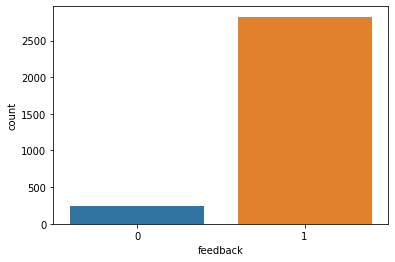

In [18]:
sns.countplot(clean_df['feedback']);

###### Observações:
-O dataset está claramente desbalanceado, a grande maioria das reviews são positivas, porém como não vamos realizar nenhuma tarefa de classificação, não precisamos nos preocupar com isso.

## Pergunta 1:
- Quais palavras são mais frequentemente usadas em críticas positivas e negativas?

### Word Cloud

Para se ser uma ideia da frequência de palavras nas reviews, vamos usar a ferramenta Word Cloud para obte-la

In [6]:
def generate_wordcloud(reviews):
    reviews = " ".join(s for s in reviews)

    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords,
                          background_color='black', width=1600,                            
                          height=800).generate(reviews)

    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(wordcloud)
    

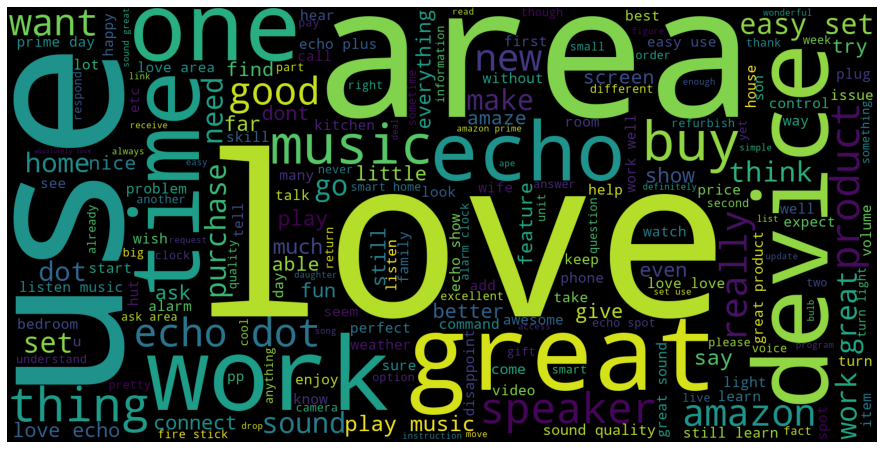

In [7]:
generate_wordcloud(clean_df['review'])

- Podemos perceber que a nossa base de palavras faz sentido, e que não tem stopwords poluindo-a.
- Outra inferência possivél é que, pela frequêcia das palavras, a maior parte das críticas são positivas, dado o tamanho das palavras: "love" e "great", e também pela dificuldade de achar alguma palavra negativa na nuvem de palavras.

### Word Cloud de reviews negativas e positivas

Para fins de comparação, vamos analisar quais palavras são mais usadas para reviews negativas e positivas
##### Negativas

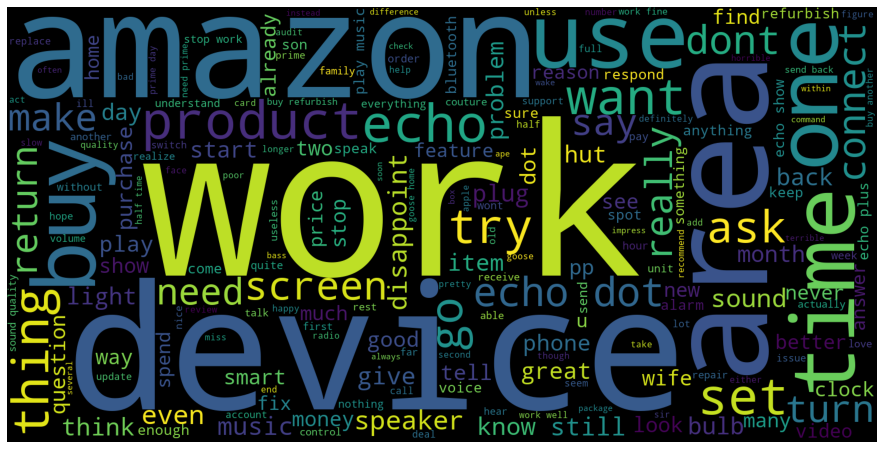

In [8]:
neg = clean_df['review'][clean_df['rating']<3]
generate_wordcloud(neg)

Observações:
- Podemos perceber que nas reviews negativas, algumas palavras como: "disappoint", "dont", "problem", "repair" tem mais destaque.
- Outras palavras interessantes nas negativas são: "amazon", provavelmente falando mal da empresa; "Return", deve se tratar sobre devolver o produto; 
- Porém, as maiores palavras das reviews negativas são "device" e "work", provavelmente relacionadas ao dispositivo não funcionar corretamente.

###### Positivas

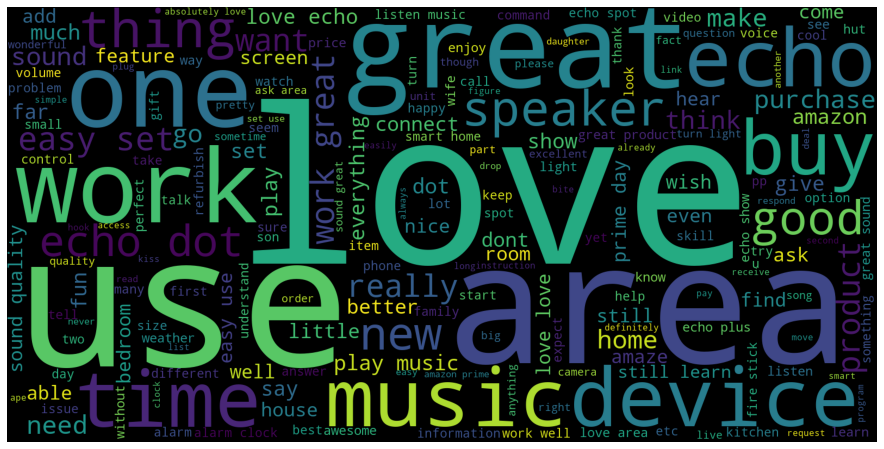

In [9]:
pos = clean_df['review'][clean_df['rating']>=3]
generate_wordcloud(pos)

Observações:
- Palavras como "love", "great", "good", "perfect", "easy", "quality" mostram que as reviews positivas seguem uma tendência

### Scattertext

Vamos usar um gráfico de dispersão para visualizar a distrubuição de palavras em relação com o tipo de review

In [10]:
nlp = en_core_web_sm.load()

In [11]:
clean_df['parsed'] = clean_df.review.apply(nlp)

In [12]:
corpus = st.CorpusFromParsedDocuments(clean_df, category_col='feedback', 
                                      parsed_col='parsed').build()

In [16]:
html = st.produce_scattertext_explorer(corpus,
                                       category='1',
                                       category_name='Positive',
                                       not_category_name='Negative',
                                       minimum_term_frequency=5,
                                       width_in_pixels=800,
                                       transform=st.Scalers.scale)
file_name = 'Conventions2012ScattertextLog.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=700)

Como o gráfico não se atêm só a quantidade de palavras, e sim pela sua frequência, ele nos dar insights menos enviesados.
###### Observações / Insights:
- O maior outlier é a palavra "love". Isso se dá pelo fato de que dificilmente quem não gostou do produto iria dizer algo a respeito de "amor".
- Porém, se observarmos a coluna "Top Positive" da direita, vemos que a palavra love não é a com maior no lado positivo, e sim a palavra "easy". Provavelmente tem haver com a facilidade de se utilizar o produto.
- Algumas palavras na coluna de "Top Positive" indicam ainda mais a teses de que as críticas seguem uma tendência, como: "fun", "great", "good", "well", "enjoy", "amaze".

- Se olharmos para a coluna "Top Negative", vemos que aqui as palavras negativas se destacam mais do que no Word Cloud, pois como ja foi mencionado, o critério usado é a frequência. Como por exemplo: "fix", "spend", "terrible" foram dificéis de se indentificar nos gráficos anteriores.
- Palavras como "back", "return", "send" provavelmente indicam devolução do produto.
- Palavras como "stop", "disappoint", "spend", "stop work", "terrible", "repair", "fix" indicam insatisfação com o produto. Mostrando mais uma vez que ha uma tendência.

## Pergunta 2:
- Quais são as palavras mais relacionadas com as principais palavras (geradas pelo scattertext) utilizadas em ambas as críticas? 

### Word2Vec

Word2vec é um modelo que pode ser usado para obter incorporações (embeddings) de palavras, e com isso saber o nivél de relação entre duas palavras.

In [14]:
#Tokenizando as palavras da review
tokens = []
for i in clean_df['review']:
    tokens.append(nltk.tokenize.word_tokenize(i))

In [68]:
wc = word2vec.Word2Vec(tokens, size=100, window=10, min_count=10, workers=4)

30-Nov-20 14:08:36 - collecting all words and their counts
30-Nov-20 14:08:36 - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
30-Nov-20 14:08:36 - collected 2933 word types from a corpus of 38696 raw words and 3062 sentences
30-Nov-20 14:08:36 - Loading a fresh vocabulary
30-Nov-20 14:08:36 - effective_min_count=10 retains 615 unique words (20% of original 2933, drops 2318)
30-Nov-20 14:08:36 - effective_min_count=10 leaves 33077 word corpus (85% of original 38696, drops 5619)
30-Nov-20 14:08:36 - deleting the raw counts dictionary of 2933 items
30-Nov-20 14:08:36 - sample=0.001 downsamples 89 most-common words
30-Nov-20 14:08:36 - downsampling leaves estimated 23749 word corpus (71.8% of prior 33077)
30-Nov-20 14:08:36 - estimated required memory for 615 words and 100 dimensions: 799500 bytes
30-Nov-20 14:08:36 - resetting layer weights
30-Nov-20 14:08:36 - training model with 4 workers on 615 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 win

###### easy

In [70]:
wc.wv.most_similar('easy')

[('take', 0.9997822642326355),
 ('simple', 0.9997726678848267),
 ('different', 0.999768078327179),
 ('time', 0.9997670650482178),
 ('use', 0.9997658729553223),
 ('night', 0.9997656345367432),
 ('give', 0.9997652173042297),
 ('great', 0.9997605085372925),
 ('feature', 0.9997550249099731),
 ('product', 0.9997522830963135)]

"easy use" e "easy product" fazem sentido, mostram que boa parte das críticas positivas se devem pela facilidade de usar a Alexa.

###### learn

In [74]:
wc.wv.most_similar('learn')

[('far', 0.9998305439949036),
 ('things', 0.9998115301132202),
 ('try', 0.9997971653938293),
 ('see', 0.9997938871383667),
 ('simple', 0.9997879266738892),
 ('enjoy', 0.9997844696044922),
 ('still', 0.9997844099998474),
 ('much', 0.9997701048851013),
 ('time', 0.999767541885376),
 ('keep', 0.9997674226760864)]

"learn things, simples, enjoy", mostram facilidade de se utilizar o produto

##### back

In [75]:
wc.wv.most_similar('back')

[('without', 0.9998998045921326),
 ('amazon', 0.9998974800109863),
 ('issue', 0.9998947381973267),
 ('even', 0.9998935461044312),
 ('come', 0.999889612197876),
 ('sure', 0.9998880624771118),
 ('see', 0.9998879432678223),
 ('skill', 0.9998819828033447),
 ('full', 0.9998798370361328),
 ('order', 0.9998796582221985)]

"back order" mostra que alguma parte das críticas negativas citam em devolver o produto de volta

###### return

In [77]:
wc.wv.most_similar('return')

[('go', 0.9998551607131958),
 ('see', 0.9998440742492676),
 ('little', 0.9998435974121094),
 ('order', 0.9998403191566467),
 ('touch', 0.9998362064361572),
 ('come', 0.9998358488082886),
 ('sure', 0.9998352527618408),
 ('give', 0.9998329281806946),
 ('wont', 0.9998324513435364),
 ('need', 0.9998319149017334)]

"return order" também indica que usuários desejam devolver o produto

## Pergunta 3:
- Se forem levadas em conta unicamente as palavras individuais usadas em críticas negativas e positivas, da para notar alguma diferença?

### Gráfico de Dispersão

In [27]:
#Usando TF-IDF para transformar o texto em uma matriz de 'TF-IDF features'
cv = TfidfVectorizer()
x = cv.fit_transform(clean_df['review'])
y = clean_df['feedback']

In [28]:
#Normilizando
std = StandardScaler(with_mean = False)
x_std = std.fit_transform(x)
x_std = x_std.todense()

In [29]:
#Usando TSNE para reduzir a dimensionalidade
model = TSNE(n_components = 2, perplexity = 20).fit_transform(x_std)

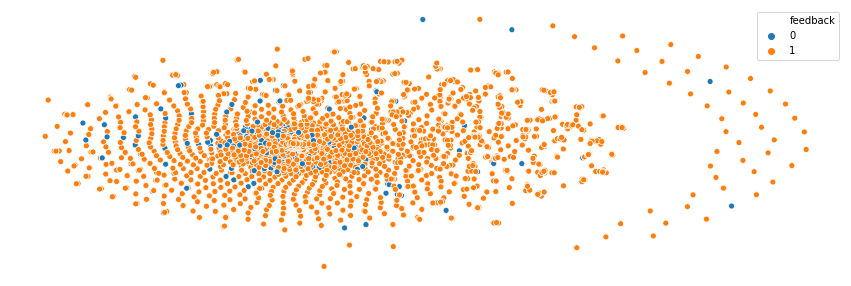

In [30]:
#Plotando os resultados
#As cores representam os dois tipos de reviews
plt.figure(figsize = (15,5))
plt.axis('off')
sns.scatterplot(model[:,0], model[:,1], hue=y);

##### Observações:
- Segundo o gráfico gerado com o TSNE, é possivel notar que ambos os tipos de crítica ocupa o mesmo lugar no gráfico de dispersão. Por isso, usando unicamente as palavras utilizadas, não é possivél diferenciar críticas positivas e negativas.
- Por este motivo, devemos ir atrás das palavras chave que compõem cada tipo de crítica.

# Keyword Extraction

###### Como o dataset esta desbalanceado, a extração das palavras chave será utilizando os dois tipos de críticas separadamente, ou seja, teremos palavras chave para críticas positivas e negativas.
- Isso será útil para podermos detectar o sentimento das críticas sem ter que analisar o texto inteiro, e sim suas palavras chave.

###### Existem muitas ferramentas de extração de palavras chave disponíveis na comunidade. Para não se ater apenas ao resultado de um só, resolvi testar alguns e comparar seus resultados.
- Infelizmente, ainda não há uma métrica bem definida para avaliar a perfomance dos modelos.
- Por isso, neste caso em específico, a métrica dos resultados será baseada nos conhecimentos obtidos pelas análises e visualizações no tópico anterior.

In [6]:
pos_text = ' '.join(clean_df['review'][clean_df['feedback']=='1'].tolist())
neg_text = ' '.join(clean_df['review'][clean_df['feedback']=='0'].tolist())

### MRaKun (um pouco lento)

https://github.com/SkBlaz/rakun

In [70]:
def mk_keywords(text):
    hyperparameters = {"distance_threshold":2,
                       "distance_method": "editdistance",
                       "num_keywords" : 20,
                       "pair_diff_length":2,
                       "bigram_count_threshold":2,
                       "num_tokens":[2],
                       "max_similar" : 1, 
                       "max_occurrence" : 1} 

    keyword_detector = RakunDetector(hyperparameters)
    keywords = keyword_detector.find_keywords(text, input_type = "text")
    return keywords

In [71]:
pos_mkkw = mk_keywords(pos_text)
neg_mkkw = mk_keywords(neg_text)

01-Dec-20 09:16:33 - Initiated a keyword detector instance.
01-Dec-20 09:17:24 - Number of nodes reduced from 2064 to 1833
01-Dec-20 09:17:54 - Initiated a keyword detector instance.
01-Dec-20 09:18:01 - Number of nodes reduced from 845 to 789


In [72]:
list_pos_mkkw = []
list_neg_mkkw = []

for i,j in zip(pos_mkkw, neg_mkkw):
    list_pos_mkkw.append(i[0])
    list_neg_mkkw.append(j[0])

mrakun_kw = pd.DataFrame({'Positive': list_pos_mkkw, 'Negative':list_neg_mkkw})

In [73]:
mrakun_kw

,Positive,Negative
0,sound play music,amazon network would
1,sound like music,amazon take thing
2,sound like music,amazon take thing
3,music echo sound,great device
4,music sleep sound,would never recommend
5,music though sound,great product
6,music echo sound,really disappoint
7,music sleep sound,touch screen
8,music though sound,connect phone
9,music love sound,great good sound


###### Observações:
- Na parte das reviews positivas, este modelo repetiu muitas palavras chave, como "music", "sound" e "amazon". E mesmo alterando o parâmentro para regularizar isso, ainda sim não funcionou.
- Podemos ver que até nas reviews negativas, algumas palavras chave positivas aparecem, como "great device" e "great product". É necessário averiguar os próximos modelos para ver se o padrão se repete.
- Podemos ver que nas reviews negativas, muitas palavras chave falam sobre aspectos técnicos do aparelho, como "touch screen", "sound", "connect internet".

### BERT (muito lento)

In [50]:
def bert_kerwords(doc):
    n_gram_range = (1, 2)

    count = CountVectorizer(ngram_range=n_gram_range).fit([doc])
    candidates = count.get_feature_names()

    model = SentenceTransformer('distilbert-base-nli-mean-tokens')
    doc_embedding = model.encode([doc])
    candidate_embeddings = model.encode(candidates)

    top_n = 20
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    return keywords

In [51]:
pos_bertkw = bert_kerwords(pos_text)
neg_bertkw = bert_kerwords(neg_text)

01-Dec-20 08:23:09 - Load pretrained SentenceTransformer: distilbert-base-nli-mean-tokens
01-Dec-20 08:23:09 - Did not find folder distilbert-base-nli-mean-tokens
01-Dec-20 08:23:09 - Try to download model from server: https://sbert.net/models/distilbert-base-nli-mean-tokens.zip
01-Dec-20 08:23:09 - Load SentenceTransformer from folder: C:\Users\Leo/.cache\torch\sentence_transformers\sbert.net_models_distilbert-base-nli-mean-tokens
01-Dec-20 08:23:10 - Use pytorch device: cpu


01-Dec-20 08:26:28 - Load pretrained SentenceTransformer: distilbert-base-nli-mean-tokens
01-Dec-20 08:26:28 - Did not find folder distilbert-base-nli-mean-tokens
01-Dec-20 08:26:28 - Try to download model from server: https://sbert.net/models/distilbert-base-nli-mean-tokens.zip
01-Dec-20 08:26:28 - Load SentenceTransformer from folder: C:\Users\Leo/.cache\torch\sentence_transformers\sbert.net_models_distilbert-base-nli-mean-tokens
01-Dec-20 08:26:29 - Use pytorch device: cpu


In [52]:
bert_kw = pd.DataFrame({'Positive': pos_bertkw, 'Negative':neg_bertkw})

In [53]:
bert_kw

,Positive,Negative
0,bluetooth connect,amazon prime
1,enjoy netflix,load netflix
2,netflix bedroom,useful amazon
3,music bluetooth,nice amazon
4,netflix easy,amazon refurbish
5,bluetooth capabilities,party ape
6,laptopdesktop cool,later netflix
7,netflix good,amazon upgrade
8,musiclaughter niceneeds,unacceptableexpected amazon
9,bluetooth great,apple devices


###### Observações:
- As palavras chave das reviews positivas focaram muito em aspectos como "bluetooth" e "netflix", não ficou muito generalizado.
- Neste modelo, não foi possível notar uma diferença entre os dois tipos de crítica, no que diz respeito as palavras chave, então geralmente não será o modelo escolhido, além de sua execução ser muito lenta.

### Gensim TextRank (rapido)

In [54]:
pos_genkw = keywords(pos_text).split('\n')[:20]
neg_genkw = keywords(neg_text).split('\n')[:20]

In [55]:
gensim_kw = pd.DataFrame({'Positive': pos_genkw, 'Negative':neg_genkw})

In [56]:
gensim_kw

,Positive,Negative
0,use,work
1,usefulness,device
2,area,devices
3,areas,time
4,likely,echo dot
5,music,area
6,purchase work,use
7,great alarm,useful
8,set,product
9,settings,products


###### Observações:
- As palavras chave positivas ficaram bem generalizadas, apontando vários aspectos positivos do produto.
- Porém as palavras chave negativas não se diferenciaram muito das positivas, muitas são repetidas. A única palavra chave negativa que se pode perceber é "disappoint", e talvez "return".

### RAKE (muito rapido)

In [57]:
Rake = RAKE.Rake(RAKE.SmartStopList())

pos_rakekw = Rake.run(pos_text, maxWords = 2)[:20]
neg_rakekw = Rake.run(neg_text, maxWords = 2)[:20]

In [58]:
list_pos_rake = []
list_neg_rake = []

for i,j in zip(pos_rakekw, neg_rakekw):
    list_pos_rake.append(i[0])
    list_neg_rake.append(j[0])

In [59]:
rake_kw = pd.DataFrame({'Positive': list_pos_rake, 'Negative':list_neg_rake})

In [60]:
rake_kw

,Positive,Negative
0,smarten politics,good music
1,charge port,random speak
2,plusprimeetc account,function perform
3,cos anymore,acknowledge command
4,quick responses,terrify refurbish
5,prime account,fix item
6,toll return,rep speak
7,read comment,price refurbish
8,today god,refurbish activate
9,step complete,unnecessary feature


###### Observações:
- A impressão que se deu aqui, é que foram perdidas muitas informações no texto das reviews positivas, visto que muitas palavras chave não fazem sentido.
- Já nas reviews negativas, o modelo conseguiu retornar algumas bem interessantes, como: "unnecessary feature", "deaf dumb", "huge potential", "terrify refurbish".

### YAKE (rapido)

https://github.com/LIAAD/yake

In [13]:
language = "en"
max_ngram_size = 2
deduplication_thresold = 0.4
deduplication_algo = 'seqm'
windowSize = 10
numOfKeywords = 20

kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_thresold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
pos_yakekw = kw_extractor.extract_keywords(pos_text)
neg_yakekw = kw_extractor.extract_keywords(neg_text)

In [14]:
list_pos_yake = []
list_neg_yake = []

for i,j in zip(pos_yakekw, neg_yakekw):
    list_pos_yake.append(i[0])
    list_neg_yake.append(j[0])

In [15]:
yake_kw = pd.DataFrame({'Positive': list_pos_yake, 'Negative':list_neg_yake})

In [16]:
yake_kw

,Positive,Negative
0,love echo,echo dot
1,work great,stop work
2,echo dot,play music
3,easy set,work echo
4,play music,buy refurbish
5,great love,sound quality
6,sound quality,half time
7,music play,send back
8,prime day,music play
9,set easy,prime day


###### Observações:
- O modelo fez um grande trabalho nas palavras chave positivas, bem generalizadas e que fazem sentido.
- Porém, como em outros modelos, não conseguiu distinguir bem as reviews negativas. Algumas palavras se repetem, e poucas são realmente negativas.

### PKE TopicRank (lento)

In [65]:
def pke_keywords(text): 
    extractor = pke.unsupervised.TopicRank()
    extractor.load_document(input=text)

    pos = {'NOUN', 'PROPN', 'ADJ'}
    extractor.candidate_selection(pos=pos)
    extractor.candidate_weighting(threshold=0.74, method='average')
    return extractor.get_n_best(n=20)

In [66]:
pos_topickw = pke_keywords(pos_text)
neg_topickw = pke_keywords(neg_text)

In [67]:
list_pos_tr = []
list_neg_tr = []

for i,j in zip(pos_topickw, neg_topickw):
    list_pos_tr.append(i[0])
    list_neg_tr.append(j[0])

In [68]:
tr_kw = pd.DataFrame({'Positive': list_pos_tr, 'Negative':list_neg_tr})

In [69]:
tr_kw

,Positive,Negative
0,area,things
1,work,device
2,echo,work echo fan
3,music,response echo dot
4,love,area
5,things,amazon apple
6,use standard,screen
7,time,speaker
8,categories nice sound play music,time
9,echo dot repeat,separate hut


###### Observações:
- O modelo fez um bom trabalho nas reviews positivas, porém outros modelos performaram melhor.
- Mais uma vez, o modelo não conseguiu distinguir bem as palavras chave das reviews negativas.

### Observações gerais:
- A maioria dos modelos apresentou boa perfomance em encontrar palavras chave das reviews positivas.
- Porém, é necessário averiguar o porque a maioria deles não perfomou bem em distinguir as palavras chave das reviews negativas.
- Depois de analisar um pouco o texto, e as palavras chave retornadas pelos modelos, deu para perceber alguns pontos interessantes:
- Algumas críticas, mesmo que negativas, elogiam o aparelho, mostrando que por isso as vezes os modelos não conseguiram performar uma distinção nas palavras chave dos dois tipos de review.
- A maioria das críticas negativas criticaram aspectos bem específicos do produto, o que causou dificuldade em perceber palavras chaves.

# Resultados

#### Como nenhum modelo apresentou uma perfomance boa nos dois tipos de críticas, uma opção é usar um modelo para cada tipo de crítica, ou seja, um modelo retorna as palavras chave das positivas, e o outro das negativas.
- Averiguando os modelos, o que melhor representou as reviews positivas foi o YAKE.
- O modelo que melhor conseguiu representar a parte negativa das críticias foi o MRakun.

#### Por isso o resultado final será uma junção dos dois modelos.

In [74]:
final = pd.DataFrame({'Positive': list_pos_yake, 'Negative': list_neg_mkkw})

In [75]:
final

,Positive,Negative
0,love echo,amazon network would
1,work great,amazon take thing
2,echo dot,amazon take thing
3,easy set,great device
4,play music,would never recommend
5,great love,great product
6,sound quality,really disappoint
7,music play,touch screen
8,prime day,connect phone
9,set easy,great good sound


##### Observações:
- É de se notar que algumas palavras positivas se encontram nas palavras chave negativas, e isso ocorre não só aqui, mas na maioria dos modelos anteriores também. Mostrando que mesmo a review sendo negativa, alguns usuários ainda assim elogiam o produto.
- Boa parte das críticas positivas são direcionadas ao sistema de som, e ao sistema de "player" do produto. Mostrando que essas features são o que boa parte dos consumidores buscam.